<a href="https://colab.research.google.com/github/yeaeunJi/deep_learning-/blob/main/Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 추론기반 기법과 신경망
- 단어를 벡터로 표현하는 방법 중 성공적인 기법은 크게 '통계 기반 기법'과 '추론 기반 기법'이 있음
- 두 방법 모두 분포 가설을 기반으로 하지만 단어의 의미를 얻는 방식이 다름
  - 분포 가설 : 단어의 의미는 주변 단어에 의해 형성된다는 가설

### 통계 기반 기법의 문제점
- 통계 기반 기법은 주변 단어의 빈도를 집계하여 단어를 표현
  - 단어의 동시발생 행렬 --> SVD로 차원 축소하여 밀집 벡터로 단어의 분산 표현을 얻음
- 통계 기반 기법 시 코퍼스(말뭉치)의 어휘 수를 N이라고 했을때, N * N의 크기의 행렬을 만들고, 이 행렬에 SVD를 적용하는 비용은  O(n의 3제곱)임. 따라서 규모가 큰 말뭉치에 적용 시 상당한 컴퓨팅 자원과 시간이 소요됨

- 통계 기반 기법은 코퍼스 전체의 통계(동시발생 행렬과 PPMI 등)을 통해 1회의 처리(SVD)만에 단어의 분산 표현을 얻음(배치학습)

- 추론 기반 기법에서는 미니배치로 대규모의 학습 데이터의 일부들을 사용하여 순자적으로 학습(미니배치학습)

- 여러 머신과 여러 GPU를 이용한 병렬 계산도 가능해져 학습 속도가 향상 가능

### 추론 기반 기법 개요
- 주변 단어(맥락)이 주어졌을 때 목표 단어에 어떤 단어가 들어가는지를 추측하는 작업을 반복하여 풀며 단어의 출현 패턴을 학습
- 맥락을 입력하면 모델은 각 단어의 출현 확률을 출력하는 작업을 통해 모델이 올바른 추축을 하도록 학습시키고, 그 결과로 단어의 분산 표현을 얻음

### 신경망에서의 단어 처리
- 신경망에서는 단어를 '고정 길이의 벡터'로 변환해야 하는데, 이때 사용하는 기법에는 대표적으로 원핫(one-hot) 표현 또는 원핫 벡터로 변환
  - 원핫 표현 : 벡터의 원소 중 하나만 1이고 나머지 원소는 모두 0인 벡터
  - 총 어휘 수 만큼의 원소를 갖는 벡터에 인덱스가 단어 ID와 같다면 1, 아니라면 0으로 설정
- 단어를 고정 길이 벡터로 변환하면 신경망의 입력층의 뉴런의 수를 고정 가능

In [2]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력층 노드 수 7
W = np.random.randn(7, 3) # 은닉층의 노드 수 3 이므로 완전연결계층의 가중치는 7*3크기
h = np.matmul(c, W) # 중간 노드 값
print(h) # 단어 ID에 대응하는 원소만 1이므로 c*W의 행렬곱은 가중치의 행벡터 하나를 뽑은 것과 같음. 따라서 다음에 개선할 예정
print(W[0]) 

[[ 1.73860873 -1.46469447  0.46299378]]
[ 1.73860873 -1.46469447  0.46299378]


In [4]:
# 행렬의 곱을 수행하는 계층 클래스
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [ ]:
# 앞에서 구현했던 MatMul 계층을 사용하여 구현할수도 있음(작동되지 않은 예시 코드로 MatMul은 )
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력층 노드 수 7
W = np.random.randn(7, 3) # 은닉층의 노드 수 3 이므로 완전연결계층의 가중치는 7*3크기
layer = MatMul(W)
h = layer.forward(c)
print(h)

## 단순한 word2vec

### CBOW(continuous bag-of-words)
- CBOW 모델은 주변 단어(맥락)로부터 타겟 단어(중앙 단어)를 추측하는 용도의 신경망
- 맥락을 입력으로 받는 모델이므로 입력할 맥락을 원핫 표현으로 변환하는 전처리 작업 필요

- 2개의 맥락을 사용한다면 입력층이 2개가 되며, 은닉층을 거쳐 출력층에 도달
  - 두 입력층에서 은닉층으로는 같은 완전연결계층(가중치공유)이 처리하고, 은닉층에서 출력층 뉴런으로의 변환은 다른 완전연결계층이 처리
  - 입력층이 여러개일 경우 전체의 평균 값이 은닉층의 값이 됨
  - 출력층 각각의 뉴런은 각각의 단어에 대응하고, 각 단어의 score(점수)임
  - 이 점수에 소프트맥스 함수를 적용하면 확률을 얻을 수 있음

- 입력층에서 은닉층으로의 변환 시 사용되는 가중치가 단어의 분산표현으로 사용됨
  - 가중치의 각 행이 해당 단어의 분산 표현
  - 학습을 진행할수록 맥락에서 출현하는 단어를 잘 추측하도록 분산 표현들이 갱신됨(단어의 의미도 녹아들어 있는 벡터를 얻게됨)

- 은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 함
  - 단어 예측에 필요한 정보를 간결하게 담고, 밀집벡터 표현을 얻을 수 있음

In [6]:
# 샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in) # 입력층의 MatMul 게층은 가중치 W_in을 공유
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0+h1)
s = out_layer.forward(h)

print(s)

[[-0.2196541  -0.61564545 -0.006366    0.75285873 -0.72388051 -1.04155523
   0.09959919]]


### CBOW 모델의 학습
- 위에서 얻은 각 단어의 점수에 소프트맥스 함수를 적용하면 '확률'을 얻을 수 있음
  - 이 확률은 맥락(전후 단어)이 주어져있을 때, 그 중앙에 어떤 단어가 출현하는 지를 나타냄

- 다중 클래스 분류를 수행하는 신경망이므로 소프트맥스와 교차 엔트로피 오차를 이용하여 신경망을 학습시킴
  - 소프트맥스 함수 : 출력층에서 얻은 점수를 확률로 변환
  - 교차 엔트로피 오차 : 소프트맥스 함수로 얻은 확률과 정답 레이블을 통해 얻은 교차 엔트로프 오차 값을 손실로 사용 가능

- 입력 측 가중치는 각 행이 각 단어의 분산 표현에 해당하고, 출력 측 가중치에도 단어의 의미가 인코딩된 벡터가 저장되어 있다고 생각 가능(열발향으로 각 단어의 분산 표현 저장)
  - 입력측의 가중치만 이용하거나 출력 측의 가중치만 이용하거나 모두 이용 가능
  - word2vec(특히 skip-gram 모델)에서는 첫번째가 대중적인 선택임

##### 전처리
- 말뭉치로부터 추측을 목표로 하는 중앙 단어(타깃)과 그 주변 단어인 '맥락'을 추출해야 함
- 타깃 : 양끝의 window size만큼의 단어를 제외한 모든 단어에 대해 수행


In [7]:
# 말뭉치를 단어 ID로 변환하는 함수
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [8]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [9]:
# 단어 ID의 배열인 corpus에서 맥락과 타깃 추출하는 함수
def create_contexts_target(corpus, window_size=1) :
  target = corpus[window_size : -window_size] # 타겟은 양쪽 끝의 윈도우사이즈만큼을 제외하여 추출
  contexts = []

  for idx in range(window_size, len(corpus)-window_size) : # 타겟 단어가 될 수 있는 단어들
    cs = [] # 해당 타겟 단어 주변 맥락 단어를 담을 배열

    for t in range(-window_size, window_size+1) : # 윈도우 크기의 범위
      if t == 0 : # 윈도우 크기 범위 안에 있는 단어가 타겟단어일 경우 제외
        continue
      cs.append(corpus[idx+t]) 
    
    contexts.append(cs) # 전체 말뭉치에 대한 맥락

  return np.array(contexts), np.array(target)


In [10]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [11]:
# 추출한 맥락과 타깃의 각 원소가 단어 ID이므로 이를 원핫 표현으로 변환
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [12]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(contexts)
print(target)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


## CBOW 모델 구현


In [52]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x
    
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


In [53]:
class SimpleCBOW :
  def __init__(self, vocab_size, hidden_size) :
    V, H = vocab_size, hidden_size

    # 가중치 초기화
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    # 계층 생성
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 =  MatMul(W_in)
    self.out_layer =  MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    # 모든 가중치와 기울기를 리스트에 모음
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []

    for layer in layers :
      self.params += layer.params
      self.grads += layer.grads
    
    # 인스턴스 변수에 단어의 분산 표현 저장
    self.word_vecs = W_in

  # 신겸앙의 순전파 forward() 메서드
  def forward(self, contexts, target) :
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0+h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss
  
  # 신경망의 역전파
  def backward(self, dout=1) :
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

In [54]:
import numpy
import matplotlib.pyplot as plt
import time
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
            
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


# 여러 계층에서 같은 가중치를 공유하고 있는데 params 리스트에 같은 가중치가 여러개 존재하게 되면
# 책에서 구현한 옵티마이저 처리 시 동작이 정상적으로 수행되지 않을 수 있음
# 따라서 매개변수 갱신 시 매개변수의 중복을 없애는  함수 사용
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [55]:
# 옵티마이저 Adam
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 2.08
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 2.07
| 에폭 26 |

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

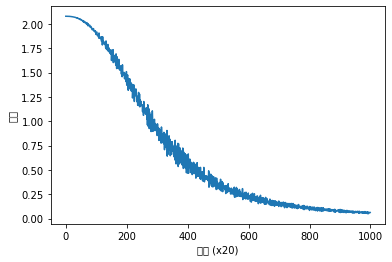

In [56]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I san hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [57]:
word_vecs = model.word_vecs

for word_id, word in id_to_word.items() :
  print(word, word_vecs[word_id]) # 대응하는 단어 ID의 분산 표현

you [-1.2783585  1.0661008  1.4041533  0.9247976 -0.7817244]
say [ 1.2863058  1.2244338  1.2751263 -1.0192852  1.2517244]
goodbye [-0.61291796  1.4156067  -0.02064987  1.4508197  -1.4567227 ]
and [ 0.31690037 -0.9133648   1.5060276  -1.4435369   0.39484617]
i [ 1.445618    1.3924631  -1.5673728  -0.35307717 -0.23363668]
san [-1.4123195  -1.4243504  -0.08328641 -0.6086579  -1.4148792 ]
hello [ 0.9752423   0.95640856 -1.1407146  -1.3155775   1.3172697 ]
. [-1.0338564 -1.121315  -1.398268   1.3216097 -1.0197542]
